In [1]:
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional,Embedding,BatchNormalization,Conv1D,GlobalAveragePooling1D,MaxPooling1D,Input,Attention
from tensorflow.keras.layers import Flatten
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import Adam

2024-09-21 19:46:32.079476: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 19:46:32.253800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 19:46:32.909324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Read CSV file
df = pd.read_csv("Balanced_sentiments.csv")

# Convert specific column to string
df["headline"] = df["headline"].astype(str)

# Save the modified DataFrame to a new CSV file
df.to_csv("Balanced_sentiments.csv", index=False)


In [3]:
df

,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,headline,label
0,0,0,0,0,0,0,0,0,market close mostly low rost panw report earning,negative
1,1,1,1,1,1,1,1,1,gap plummet earning miss cut fullyear forecast,negative
2,2,2,2,2,2,2,2,2,billionaire ken fisher sell 10 stock,negative
3,3,3,3,3,3,3,3,3,corn net income drop 13 share fall,negative
4,4,4,4,4,4,4,4,4,internet explorer shutdown cause japan problem...,negative
...,...,...,...,...,...,...,...,...,...,...
30840,30840,30840,30840,30840,30840,30840,30840,30840,london marketwatch share price end low london ...,negative
30841,30841,30841,30841,30841,30841,30841,30841,30841,rinkuskiai beer sale fall 65 per cent 416 mill...,neutral
30842,30842,30842,30842,30842,30842,30842,30842,30842,operate profit fall our 354 in our 688 in 2007...,negative
30843,30843,30843,30843,30843,30843,30843,30843,30843,net sale paper segment decrease our 2216 in se...,negative


In [4]:
df1 = df[df["label"]=="positive"]
df1.shape

(13811, 10)

In [5]:
df2 = df[df["label"]=="neutral"]
df2.shape

(11626, 10)

In [6]:
df3 = df[df["label"]=="negative"]
df3.shape

(5408, 10)

In [7]:
df["word_count"] = df["headline"].apply(lambda x:len(str(x).split()))
total_words = df["word_count"].sum()
total_words

283937

In [8]:
input_length = 60

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
text_labels = ["positive", "negative","neutral"]
label_encoder.fit(text_labels)

y = label_encoder.transform(df["label"])
y

array([0, 0, 0, ..., 0, 0, 0])

## Word2Vec Model

In [10]:
from sklearn.model_selection import train_test_split
X_data, y_data = np.array(df['headline']), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.2, random_state = 42)
print('Data Split done.')
X_train.shape

Data Split done.


(24676,)

In [11]:

from gensim.models import Word2Vec

Embedding_dimensions = 128

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
len(Word2vec_train_data)

24676

In [12]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 window=5,
                 workers=6,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 5055


In [13]:
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)





In [14]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 
vocab_size

21767

In [15]:
embedding_matrix = np.zeros((vocab_size, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)



Embedding Matrix Shape: (21767, 128)


## Creating Bi-Directioal LSTM Model

## Training Bi-LSTM

In [16]:
paded_sequences = pad_sequences(train_sequences, maxlen=input_length,padding="post",truncating="post")
test_paded_sequences = pad_sequences(test_sequences, maxlen=input_length,padding="post",truncating="post")
paded_sequences[50]

array([   20,   624,  2939,  1508,   341,   829, 11169,  6635,   652,
       11170,  6636,   207,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [17]:
X_train.shape

(24676,)

In [18]:
model = Sequential([Embedding(input_dim=vocab_size,
                              output_dim=128,
                              weights=[embedding_matrix],
                              input_length=input_length),
                   Bidirectional(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2))),
                   ##Dropout(0.2),
                   Bidirectional(LSTM(100,return_sequences=False,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2))),
                   ##Dropout(0.2),
                   Dense(16, activation='relu'),
                   Dense(3,activation="softmax")])


/home/vulcan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-09-03 14:47:33.231574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-03 14:47:33.261410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-03 14:47:33.265605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1),

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,786,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,786,176 (10.63 MB)

 Trainable params: 2,786,176 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
y_train

array([0, 1, 0, ..., 0, 2, 2])

In [21]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001),  
              metrics=['accuracy'])


In [22]:
##
model.fit(paded_sequences, y_train, epochs=15, batch_size=32,validation_split=0.2)


Epoch 1/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.5121 - loss: 1.6410 - val_accuracy: 0.6262 - val_loss: 0.9829
Epoch 2/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms/step - accuracy: 0.6944 - loss: 0.8569 - val_accuracy: 0.6700 - val_loss: 0.8477
Epoch 3/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - accuracy: 0.8170 - loss: 0.5559 - val_accuracy: 0.6663 - val_loss: 0.8566
Epoch 4/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - accuracy: 0.8736 - loss: 0.4033 - val_accuracy: 0.6627 - val_loss: 1.0007
Epoch 5/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/step - accuracy: 0.8922 - loss: 0.3479 - val_accuracy: 0.6513 - val_loss: 1.0298
Epoch 6/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9128 - loss: 0.2941 - val_accuracy: 0.6544 - val_loss: 1.1541
Epoch 7/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9174 - loss: 0.2767 - val_accuracy: 0.6503 - val_loss: 1.0939
Epoch 8/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 68s 111ms/step - accuracy: 0.9304 - loss: 0

In [23]:
df

,Unnamed: 0,headline,label,word_count
0,0,market close mostly low rost panw report earning,negative,8
1,1,gap plummet earning miss cut fullyear forecast,negative,7
2,2,billionaire ken fisher sell 10 stock,negative,6
3,3,corn net income drop 13 share fall,negative,7
4,4,internet explorer shutdown cause japan problem...,negative,7
...,...,...,...,...
30840,30840,london marketwatch share price end low london ...,negative,17
30841,30841,rinkuskiai beer sale fall 65 per cent 416 mill...,neutral,21
30842,30842,operate profit fall our 354 in our 688 in 2007...,negative,17
30843,30843,net sale paper segment decrease our 2216 in se...,negative,29


In [24]:
y_test

array([0, 2, 2, ..., 0, 2, 2])

## 1 for Neutral
## 0 For Negative
## 2 For Positive


In [25]:
predictions = model.predict(test_paded_sequences)
predicted_labels = [tf.argmax(pred).numpy() for pred in predictions]
print(f"Predictions: {predicted_labels}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Predictions: [0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 2, 0, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1,

In [26]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
test_loss, test_acc = model.evaluate(test_paded_sequences, y_test)

193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6497 - loss: 1.6269


In [28]:
model.save("Sentiment_model_.hdf5")

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted_labels))

              precision    recall  f1-score   support

           0       0.63      0.53      0.57      1054
           1       0.63      0.66      0.65      2365
           2       0.66      0.68      0.67      2750

    accuracy                           0.65      6169
   macro avg       0.64      0.62      0.63      6169
weighted avg       0.65      0.65      0.65      6169



Text(0.5, 1.0, 'Confusion Matrix')

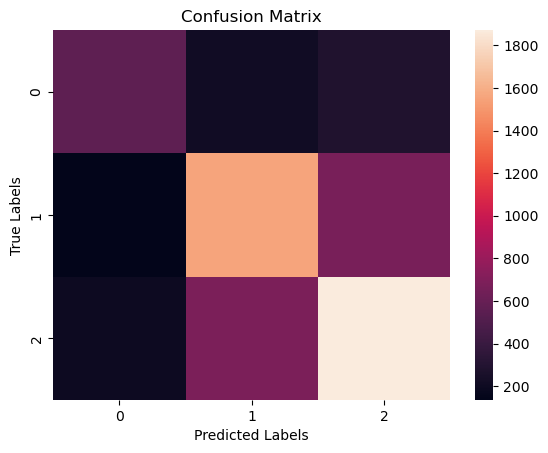

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,predicted_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [38]:
x = "corn net income drop 13 share fall"
words = len(str(x).split())
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(x)
test_sequences = tokenizer.texts_to_sequences(x)
test_paded_sequences = pad_sequences(test_sequences,maxlen=60,padding="post",truncating="post")

In [39]:
test_paded_sequences

array([[5, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       ...,
       [6, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [40]:
from scipy import stats

In [42]:
predictions = model.predict(test_paded_sequences)
predicted_labels = [tf.argmax(pred).numpy() for pred in predictions]
mode_label = np.bincount(predicted_labels).argmax()
print(mode_label)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0


In [18]:
# Define the Functional API model

# Input layer
inputs = Input(shape=(input_length,))

# Embedding layer
embedding = Embedding(vocab_size, Embedding_dimensions, input_length=input_length)(inputs)

# CNN layer to extract local features
conv1d = Conv1D(filters=64, kernel_size=3, activation='relu',padding="valid")(embedding)
maxpool = MaxPooling1D(pool_size=3)(conv1d)

conv1d_ = Conv1D(filters=64, kernel_size=3, activation='relu',padding="valid")(maxpool)
maxpool_ = MaxPooling1D(pool_size=3)(conv1d_)

# Bi-LSTM layers with dropout
bi_lstm_1 = Bidirectional(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2)))(maxpool_)

bi_lstm_2 = Bidirectional(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2)))(bi_lstm_1)

# Attention mechanism
attention_output = Attention()([bi_lstm_2, bi_lstm_2, bi_lstm_2])

# Dropout after attention layer
dropout_attention = Dropout(0.25)(attention_output)

# Global Average Pooling
pooled_output = Flatten()(dropout_attention)

# Dense output layer for classification
dense_output = Dense(3, activation='sigmoid')(pooled_output)

# Build the model
model2 = Model(inputs=inputs, outputs=dense_output)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model2.summary()


/home/vulcan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-09-19 22:55:45.419903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 22:55:45.508508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 22:55:45.510418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1),

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 128)   │  2,786,176 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 58, 64)    │     24,640 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 19, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 17, 64)    │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 5, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 5, 200)    │    132,000 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 5, 200)    │    240,800 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 200)    │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 200)    │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1000)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      3,003 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,198,971 (12.20 MB)

 Trainable params: 3,198,971 (12.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model2.fit(paded_sequences, y_train, epochs=15, batch_size=32,validation_split=0.2)


Epoch 1/15


2024-09-19 22:55:50.091794: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


617/617 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.4744 - loss: 1.5072 - val_accuracy: 0.5225 - val_loss: 0.9375
Epoch 2/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5682 - loss: 0.8212 - val_accuracy: 0.5026 - val_loss: 0.8609
Epoch 3/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6109 - loss: 0.6689 - val_accuracy: 0.6256 - val_loss: 0.8508
Epoch 4/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8060 - loss: 0.4647 - val_accuracy: 0.6613 - val_loss: 0.9235
Epoch 5/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9226 - loss: 0.2395 - val_accuracy: 0.6635 - val_loss: 1.0261
Epoch 6/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9617 - loss: 0.1355 - val_accuracy: 0.6607 - val_loss: 1.1697
Epoch 7/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9734 - loss: 0.1048 - val_accuracy: 0.6524 - val_loss: 1.4751
Epoch 8/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9805 - loss: 0.0806 - val_accuracy: 0.65

In [20]:
predictions = model2.predict(test_paded_sequences)
predicted_labels = [tf.argmax(pred).numpy() for pred in predictions]
print(f"Predictions: {predicted_labels}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions: [0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 

In [21]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted_labels))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62      1054
           1       0.72      0.57      0.63      2365
           2       0.62      0.79      0.70      2750

    accuracy                           0.66      6169
   macro avg       0.68      0.64      0.65      6169
weighted avg       0.67      0.66      0.66      6169



Text(0.5, 1.0, 'Confusion Matrix')

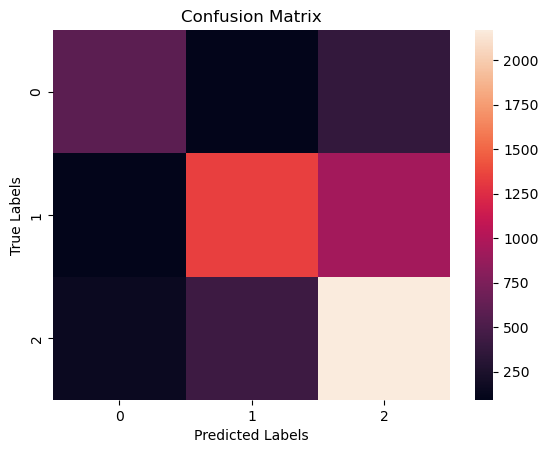

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,predicted_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [35]:
model2.save("model2_.hdf5")

In [41]:
# Define the Functional API model

# Input layer
inputs = Input(shape=(input_length,))

# Embedding layer
embedding = Embedding(vocab_size, Embedding_dimensions, input_length=input_length)(inputs)

# CNN layer to extract local features
conv1d = Conv1D(filters=64, kernel_size=3, activation='relu',padding="valid")(embedding)
batch = BatchNormalization()(conv1d)
drop = Dropout(0.2)(batch)
maxpool = MaxPooling1D(pool_size=3)(drop)

conv1d_ = Conv1D(filters=64, kernel_size=3, activation='relu',padding="valid")(maxpool)
batch_normalization_ = BatchNormalization()(conv1d_)
out = Dropout(0.2)(batch_normalization_)
maxpool_ = MaxPooling1D(pool_size=3)(out)

# Bi-LSTM layers with dropout
bi_lstm_1 = Bidirectional(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2)))(maxpool_)

bi_lstm_2 = Bidirectional(LSTM(100,return_sequences=True,kernel_regularizer=l2(0.001),recurrent_regularizer=l2(0.001),
                                      bias_regularizer=l2(0.001),dropout=(0.2),recurrent_dropout=(0.2)))(bi_lstm_1)

# Attention mechanism
attention_output = Attention()([bi_lstm_2, bi_lstm_2, bi_lstm_2])

# Dropout after attention layer
dropout_attention = Dropout(0.2)(attention_output)

# Global Average Pooling
pooled_output = Flatten()(dropout_attention)

# Dense output layer for classification
dense_output = Dense(3, activation='sigmoid')(pooled_output)

# Build the model
model3 = Model(inputs=inputs, outputs=dense_output)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model3.summary()


/home/vulcan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 60, 128)   │  2,786,176 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 58, 64)    │     24,640 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 64)    │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 58, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 19, 64)    │          0 │ dropout_12[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 17, 64)    │     12,352 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 64)    │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 17, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 5, 64)     │          0 │ dropout_13[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 5, 200)    │    132,000 │ max_pooling1d_9[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 5, 200)    │    240,800 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 5, 200)    │          0 │ bidirectional_9[… │
│ (Attention)         │                   │            │ bidirectional_9[… │
│                     │                   │            │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 5, 200)    │          0 │ attention_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1000)      │          0 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │      3,003 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,199,483 (12.21 MB)

 Trainable params: 3,199,227 (12.20 MB)

 Non-trainable params: 256 (1.00 KB)

In [42]:
model3.fit(paded_sequences, y_train, epochs=15, batch_size=32,validation_split=0.2)


Epoch 1/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5357 - loss: 1.5962 - val_accuracy: 0.6588 - val_loss: 0.9225
Epoch 2/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7823 - loss: 0.6715 - val_accuracy: 0.6469 - val_loss: 0.8356
Epoch 3/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8716 - loss: 0.4044 - val_accuracy: 0.6708 - val_loss: 0.8788
Epoch 4/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9149 - loss: 0.2770 - val_accuracy: 0.6710 - val_loss: 0.9262
Epoch 5/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9333 - loss: 0.2209 - val_accuracy: 0.6679 - val_loss: 1.0818
Epoch 6/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9439 - loss: 0.1883 - val_accuracy: 0.6706 - val_loss: 1.2036
Epoch 7/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9584 - loss: 0.1441 - val_accuracy: 0.6396 - val_loss: 1.4587
Epoch 8/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9593 - loss: 0.1386 - val_ac

In [43]:
predictions = model3.predict(test_paded_sequences)
predicted_labels = [tf.argmax(pred).numpy() for pred in predictions]
print(f"Predictions: {predicted_labels}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predictions: [0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 

In [46]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted_labels))

              precision    recall  f1-score   support

           0       0.68      0.58      0.62      1054
           1       0.68      0.65      0.67      2365
           2       0.67      0.74      0.70      2750

    accuracy                           0.68      6169
   macro avg       0.68      0.66      0.66      6169
weighted avg       0.68      0.68      0.68      6169



Text(0.5, 1.0, 'Confusion Matrix')

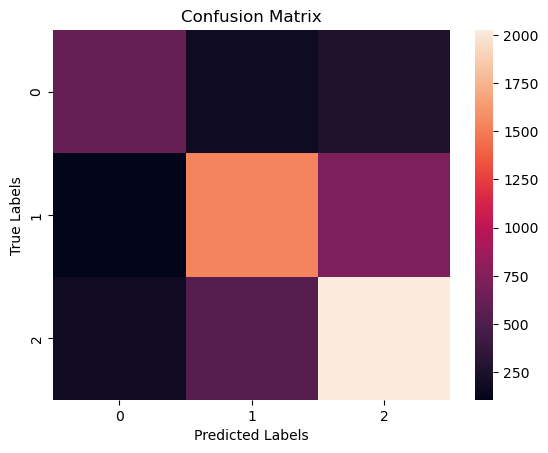

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,predicted_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [28]:
model3.save("model_refined.hdf5")

In [35]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Dropout, MaxPooling1D, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the Functional API model

# Input layer
inputs = Input(shape=(input_length,))

# Embedding layer
embedding = Embedding(vocab_size, Embedding_dimensions, input_length=input_length)(inputs)

# CNN layer to extract local features
conv1d = Conv1D(filters=64, kernel_size=3, activation='relu', padding="valid")(embedding)
batch = BatchNormalization()(conv1d)
drop = Dropout(0.2)(batch)
maxpool = MaxPooling1D(pool_size=3)(drop)

conv1d_ = Conv1D(filters=64, kernel_size=3, activation='relu', padding="valid")(maxpool)
batch_normalization_ = BatchNormalization()(conv1d_)
out = Dropout(0.2)(batch_normalization_)
maxpool_ = MaxPooling1D(pool_size=3)(out)

# Bi-LSTM layers with dropout
bi_lstm_1 = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001), 
                               recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001), 
                               dropout=0.2, recurrent_dropout=0.2))(maxpool_)

bi_lstm_2 = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001), 
                               recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001), 
                               dropout=0.2, recurrent_dropout=0.2))(bi_lstm_1)

# Multi-Head Attention mechanism (using scaled dot-product attention)
multi_head_attention = MultiHeadAttention(num_heads=4, key_dim=100)(bi_lstm_2, bi_lstm_2)

# Dropout after multi-head attention layer
dropout_attention = Dropout(0.2)(multi_head_attention)

# Global Average Pooling
pooled_output = Flatten()(dropout_attention)

# Dense output layer for classification
dense_output = Dense(3, activation='softmax')(pooled_output)  # Changed to softmax for multi-class classification

# Build the model
model4 = Model(inputs=inputs, outputs=dense_output)

# Compile the model
model4.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model4.summary()


/home/vulcan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 60, 128)   │  2,786,176 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 58, 64)    │     24,640 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 64)    │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 19, 64)    │          0 │ dropout_8[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 17, 64)    │     12,352 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 64)    │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 17, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 5, 64)     │          0 │ dropout_9[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 5, 200)    │    132,000 │ max_pooling1d_7[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 5, 200)    │    240,800 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 200)    │    321,400 │ bidirectional_7[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 5, 200)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1000)      │          0 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │      3,003 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,520,883 (13.43 MB)

 Trainable params: 3,520,627 (13.43 MB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
model4.fit(paded_sequences, y_train, epochs=15, batch_size=32,validation_split=0.2)


Epoch 1/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5300 - loss: 1.5671 - val_accuracy: 0.6455 - val_loss: 0.9316
Epoch 2/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7712 - loss: 0.6927 - val_accuracy: 0.6556 - val_loss: 0.8431
Epoch 3/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8594 - loss: 0.4254 - val_accuracy: 0.5930 - val_loss: 1.3367
Epoch 4/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9083 - loss: 0.2903 - val_accuracy: 0.6532 - val_loss: 1.0422
Epoch 5/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9290 - loss: 0.2335 - val_accuracy: 0.6436 - val_loss: 1.0911
Epoch 6/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9417 - loss: 0.1909 - val_accuracy: 0.6736 - val_loss: 1.1241
Epoch 7/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9518 - loss: 0.1601 - val_accuracy: 0.6706 - val_loss: 1.0418
Epoch 8/15
617/617 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9578 - loss: 0.1495 - val_acc

In [37]:
predictions = model4.predict(test_paded_sequences)
predicted_labels = [tf.argmax(pred).numpy() for pred in predictions]
print(f"Predictions: {predicted_labels}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions: [0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted_labels))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65      1054
           1       0.72      0.60      0.65      2365
           2       0.69      0.76      0.72      2750

    accuracy                           0.68      6169
   macro avg       0.67      0.68      0.67      6169
weighted avg       0.69      0.68      0.68      6169



Text(0.5, 1.0, 'Confusion Matrix')

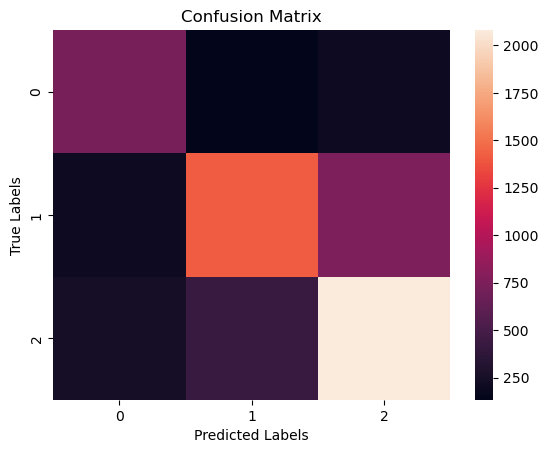

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,predicted_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [40]:
model4.save("final_model.hdf5")